In [5]:
import pandas as pd
import gc
import sys
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
src_path = os.path.abspath(r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src')
sys.path.append(src_path)

from adtk.data import validate_series
from adtk.detector import QuantileAD, ThresholdAD
from adtk.visualization import plot

from feature_engineering.encoding import group_low_frequency_categories, encode_categories, log_encode
from feature_engineering.new_features import calculate_time_delta, extract_bin, extract_check_digit, extract_datetime_component, average_transactions_per_time, transactions_in_last_interval,transactions_last_minute
from data.db_functions import query_data
from data.clean_data import update_dtypes

gc.collect()

642

In [6]:
df = pd.read_pickle(r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\notebooks\df.pkl')
df.head()

,business_id,auth_status,eci,descriptor,auth_failure_reason,charge_failure_reason,amount,authorized_amount,mid_label,bank_merchant_id,...,check_digit,business_delta,bin_delta,month,day,hour,minute,time,mean_transactions_time,last_1M_count
0,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,1449.000000,1449.000000,MPGS_GLOBE_BILLSPAY,073006686104,...,7,210.436,19284.574,2,4,20,59,20:59,0.813716,NaN
1,640fdf71d95a90ebc209167d,USED,2.0,"GLOBE TELECOM, INC.",NaN,NaN,599.000000,599.000000,MPGS_GLOBE_BILLSPAY,073006686104,...,2,135.558,14494.413,2,4,21,28,21:28,1.097433,NaN
2,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,99.000000,99.000000,MPGS_GLOBE_WEBLOADING_EC,073006686105,...,6,105.680,203.316,2,4,21,34,21:34,0.989068,NaN
3,640fdf71d95a90ebc209167d,USED,2.0,"GLOBE TELECOM, INC.",NaN,NaN,99.000000,99.000000,MPGS_GLOBE_WEBLOADING_EC,073006686105,...,4,3.430,4265.466,2,4,21,44,21:44,0.959515,NaN
4,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,758.940002,758.940002,MPGS_GLOBE_BILLSPAY,073006686104,...,2,0.563,6537.907,2,4,21,45,21:45,1.041280,NaN


(1015500, 38)
(1015500, 39)


C:\Users\User\AppData\Local\Temp\ipykernel_37572\1510634384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['anomaly'] = anomalies


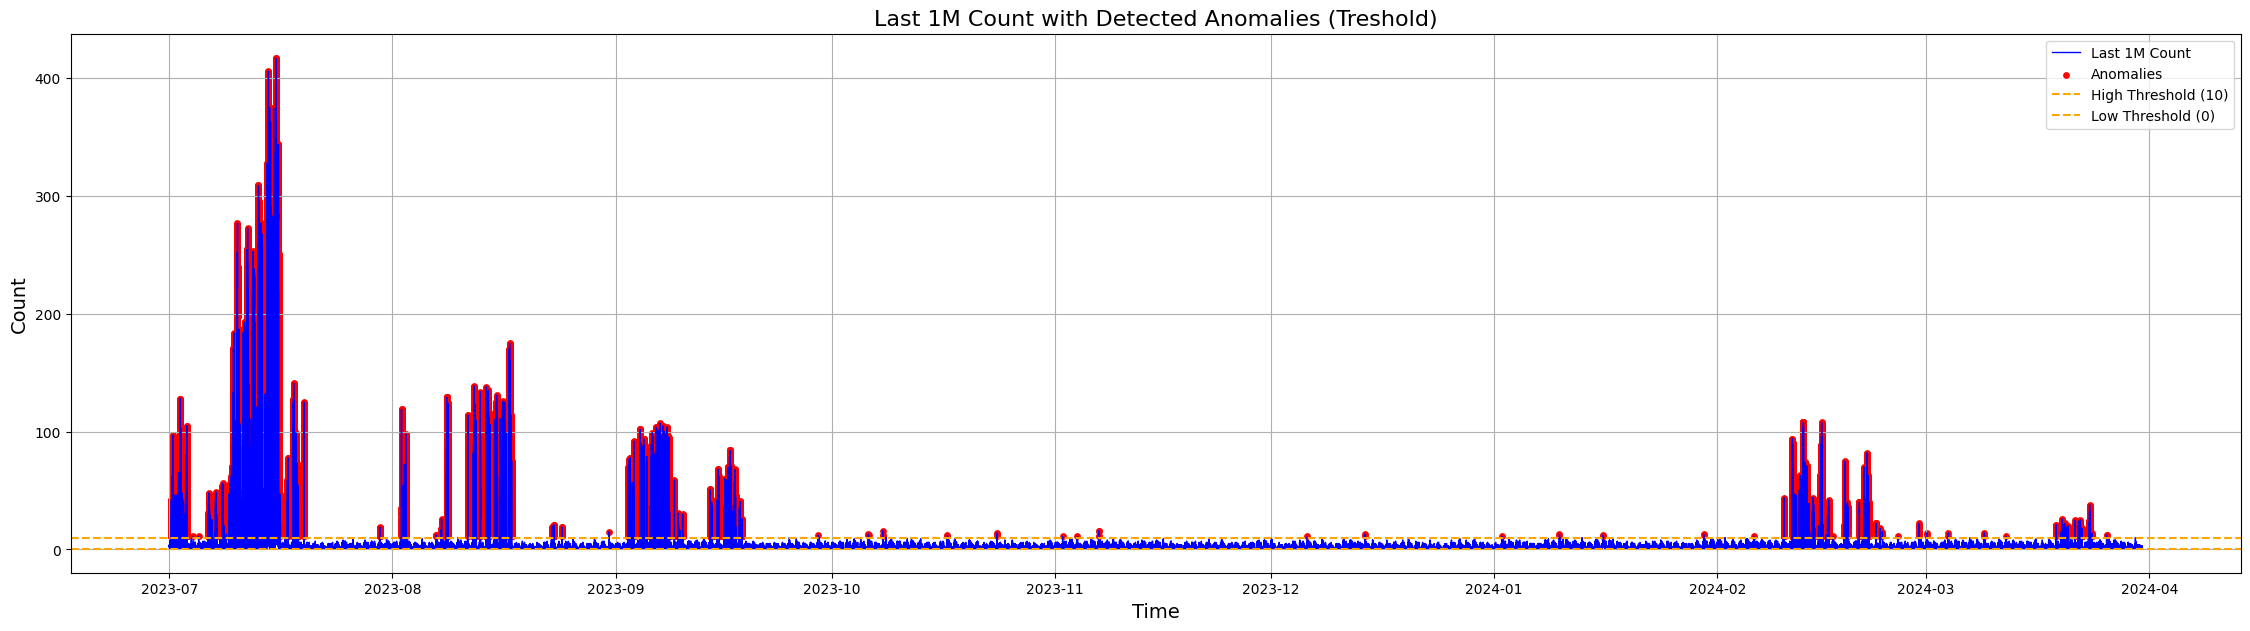

In [3]:
df_copy = df[df['charge_failure_reason'].notna()]

df_copy.set_index('created', inplace=True)

# Validate the last_1M_count series
last_1M_count_series = validate_series(df_copy['last_1M_count'])
print(df_copy.shape)

# Set up ThresholdAD with desired thresholds
# Adjust these values based on your data context
treshold = 10
threshold_ad = ThresholdAD(high=treshold, low=0)  # Example thresholds

# Detect anomalies
anomalies = threshold_ad.detect(last_1M_count_series)

# Add the anomalies to the DataFrame
df_copy['anomaly'] = anomalies
print(df_copy.shape)

# Visualize the results using matplotlib
plt.figure(figsize=(28, 7))

# Plot the time series data
plt.plot(last_1M_count_series.index, last_1M_count_series.values, label='Last 1M Count', color='blue', linewidth=1)

# Plot the anomalies
anomaly_indices = last_1M_count_series.index[anomalies]  # Get the indices of the anomalies
plt.scatter(anomaly_indices, last_1M_count_series[anomalies], color='red', label='Anomalies', marker='o', s=15)

# Add titles and labels
plt.title('Last 1M Count with Detected Anomalies (Treshold)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.axhline(y=treshold, color='orange', linestyle='--', label=f'High Threshold ({treshold})')
plt.axhline(y=0, color='orange', linestyle='--', label='Low Threshold (0)')
plt.legend()
plt.grid()
plt.show()

In [22]:
df = df.sort_values(by=['card_bin', 'created'], ascending=[True, True])
df_copy = df_copy.sort_values(by=['card_bin', 'created'], ascending=[True, True])

x = df_copy[['check_digit', 'card_bin', 'masked_card_number', 'charge_failure_reason','last_1M_count']]
x = x[x['last_1M_count'] < 10]
x = x.sort_values(by=['card_bin', 'created'], ascending=[True, True])
x['masked_card_number'].value_counts()

masked_card_number
47484409XXXX5762    34
55404505XXXX4310    32
47484404XXXX7323    23
42214986XXXX9045    21
41539930XXXX4343    20
                    ..
53558526XXXX8385     1
53558554XXXX2431     1
53558503XXXX8507     1
53558513XXXX5148     1
55999443XXXX0874     1
Name: count, Length: 72833, dtype: Int64